In [8]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
# from imblearn.under_sampling import RandomUnderSampler
# import cufflinks as cf
import researchpy as rp
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import statsmodels.api as sm
import pingouin as pg
from statsmodels.compat import lzip
from pingouin import pairwise_gameshowell, pairwise_tukey, pairwise_corr
sns.set(context='notebook', style='whitegrid', palette='Set2', font='sans-serif',
       font_scale=1.2, color_codes=True, rc={'figure.figsize':(20.7,20.27)})
%matplotlib inline

In [9]:
adni = pd.read_csv('../database_split/database_info/ADNI_experiment_information.csv')
adni = adni[['Subject ID', 'Research Group', 'MMSE Total Score', 'Visit']]
adni['Image Filename'] = adni[['Subject ID', 'Visit']].apply(lambda x: x[0]+'_'+x[1].replace(' ', '_').replace('/', ''), axis=1)

In [10]:
cn = pd.read_csv('../predict_results/test_70-100_LR_holds.csv', sep=',')
cn['Research Group'] = 'CN'
ad = pd.read_csv('../predict_results/ad_70-100_LR_holds.csv', sep=',')
ad['Research Group'] = 'AD'
mci= pd.read_csv('../predict_results/mci_70-100_LR_holds.csv', sep=',')
mci['Research Group'] = 'MCI'
results = pd.concat([cn, ad, mci]).reset_index(drop=True)
results = results[['Name', 'True', 'Pred', 'Research Group']]
results.columns = ['Image Filename', 'Chronological age', 'Estimated age', 'Research Group']
results.head()

,Image Filename,Chronological age,Estimated age,Research Group
0,023_S_4164_ADNI2_Month_6-New_Pt,73.6,78.10059,CN
1,014_S_4093_ADNI2_Month_6-New_Pt,70.6,76.46625,CN
2,021_S_0647_ADNI_Screening,72.9,74.11468,CN
3,019_S_4835_ADNI2_Year_1_Visit,80.4,75.64610,CN
4,022_S_4320_ADNI2_Month_6-New_Pt,71.5,76.68798,CN


In [11]:
data = adni.merge(results, on=['Image Filename', 'Research Group']).reset_index(drop=True)
data.columns = ['Subject ID', 'group', 'MMSE', 'Visit', 'Image Filename','Chronological age', 'Estimated age']
data['Delta'] = data[['Chronological age', 'Estimated age']].apply(lambda x: x['Estimated age'] - x['Chronological age'], axis=1)
data.columns

Index(['Subject ID', 'group', 'MMSE', 'Visit', 'Image Filename',
       'Chronological age', 'Estimated age', 'Delta'],
      dtype='object')

In [12]:
rp.summary_cont(data.groupby(['group']))['Delta'].round(2)

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
AD,209,5.01,4.97,0.34,4.33,5.68
CN,302,0.82,5.07,0.29,0.25,1.39
MCI,251,3.40,5.32,0.34,2.74,4.07


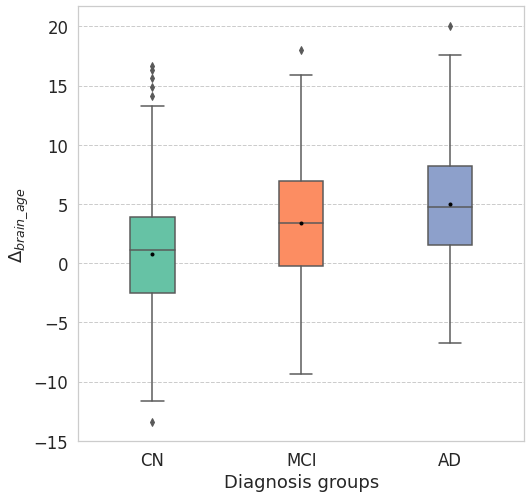

In [13]:
fig= plt.figure(figsize=(8,8))
sns.set(context='notebook', style='white', palette='Set2', font='sans-serif',
       font_scale=1.5, color_codes=True, rc={'figure.figsize':(20.7,20.27)})

sns.set_style("whitegrid", {'grid.linestyle': '--'})

dt = data[['Delta', 'group']]
dt.columns = [r'$\Delta_{ brain\_age}$', 'Diagnosis groups']
sns.boxplot(x="Diagnosis groups", y=r'$\Delta_{ brain\_age}$', order=['CN', 'MCI', 'AD'],
            showmeans=True, 
            saturation=1.5,
            meanprops={"marker":"o",
                       "markersize":3,
                       "markerfacecolor":"k",
                       "markeredgecolor":"k"
                      },  
                       data=dt, width=0.3)
plt.savefig("anova_boxplot.pdf", bbox_inches='tight', dpi=300)

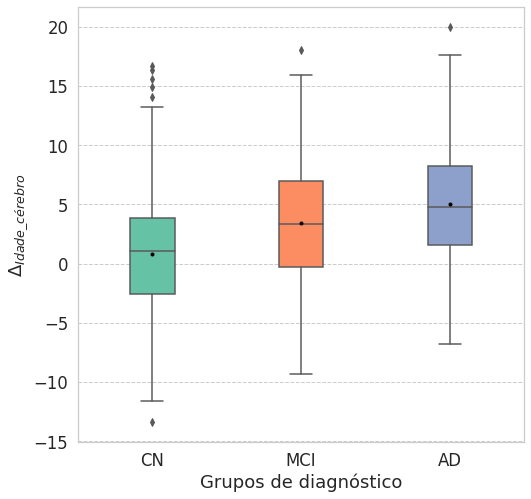

In [15]:
fig = plt.figure(figsize=(8, 8))
sns.set(context='notebook', style='white', palette='Set2', font='sans-serif',
        font_scale=1.5, color_codes=True, rc={'figure.figsize': (20.7, 20.27)})

sns.set_style("whitegrid", {'grid.linestyle': '--'})

dt = data[['Delta', 'group']]
dt.columns = [r'$\Delta_{ Idade\_cérebro}$', 'Grupos de diagnóstico']
sns.boxplot(x="Grupos de diagnóstico", y=r'$\Delta_{ Idade\_cérebro}$', order=['CN', 'MCI', 'AD'],
            showmeans=True,
            saturation=1.5,
            meanprops={"marker": "o",
                       "markersize": 3,
                       "markerfacecolor": "k",
                       "markeredgecolor": "k"
                       },
            data=dt, width=0.3)
plt.savefig("anova_boxplot_pt.pdf", bbox_inches='tight', dpi=300)


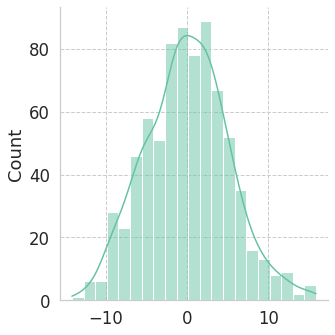

In [7]:
# Get model residuals
slr_results1 = ols('Delta ~ C(group)', data=data).fit()
sns.displot(slr_results1.resid, kde=True)

In [38]:
# Test ANOVA conditions
# Shapiro: h0:  normal distribution.
alpha = 0.01
_, p_value = stats.shapiro(slr_results1.resid)
print(p_value, "Normal" if p_value>alpha else "Not normal")
# Equal variance
homs = pg.homoscedasticity(data, dv='Delta', group='group', method="levene", alpha=alpha)
print(homs.pval[0], "Equal var" if homs.equal_var[0] else "Not equal var")

0.4248112738132477 Normal
0.006095047609058738 Not equal var


In [39]:
data[data.group=='CN']['Delta'].var(), data[data.group=='MCI']['Delta'].var(), data[data.group=='AD']['Delta'].var()

(19.532602855723553, 28.331836260930938, 24.725740648445154)

In [40]:
data[data.group=='CN'].shape, data[data.group=='MCI'].shape, data[data.group=='AD'].shape

((302, 8), (251, 8), (209, 8))

In [41]:
slr_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Delta   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     38.14
Date:                Mon, 21 Jun 2021   Prob (F-statistic):           1.64e-16
Time:                        14:44:46   Log-Likelihood:                -2288.2
No. Observations:                 762   AIC:                             4582.
Df Residuals:                     759   BIC:                             4596.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.0058      0.338     14.817      0.000       4.343       5.669
C(group)[T.CN]     -3.7684      0.439     -8.575      0.000      -4.631      -2.906
C(group)[T.MCI]    -1.6022      0.457     -3.503      0.000      -2.500      -0.704
==============================================================================
Omnibus:                        0.341   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.430
Skew:                           0.036   Prob(JB):                        0.806
Kurtosis:                       2.909   Cond. No.                         4.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
pg.anova(data=data, dv='Delta', between='group', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,group,1819.794779,2,909.897389,38.144351,1.639689e-16,0.091332
1,Within,18105.226580,759,23.854053,NaN,NaN,NaN


In [43]:
pairwise_tukey(data=data, dv='Delta', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,AD,CN,5.005798,1.237411,3.768387,0.439456,8.575128,0.001000,0.770431
1,AD,MCI,5.005798,3.403633,1.602165,0.457351,3.503138,0.001413,0.327502
2,CN,MCI,1.237411,3.403633,-2.166222,0.417161,-5.192777,0.001000,-0.442925


In [44]:
pg.pairwise_ttests(dv='Delta', between='group', data=data, alpha=0.01, effsize='hedges', padjust='bonferroni')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,group,AD,CN,False,True,8.809491,412.416230,two-sided,3.529296e-17,1.058789e-16,bonferroni,2.358e+14,0.808608
1,group,AD,MCI,False,True,3.332203,451.952572,two-sided,9.323725e-04,2.797118e-03,bonferroni,21.468,0.309590
2,group,CN,MCI,False,True,-5.140893,486.039075,two-sided,3.969865e-07,1.190960e-06,bonferroni,2.873e+04,-0.446012


Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AD     CN  -3.7684  0.001 -5.0526 -2.4841   True
    AD    MCI  -1.6022 0.0014 -2.9387 -0.2656   True
    CN    MCI   2.1662  0.001  0.9471  3.3853   True
----------------------------------------------------
/home/kpoloni/.local/lib/python3.6/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


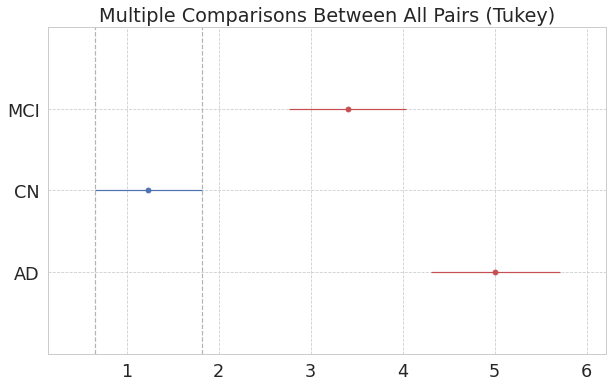

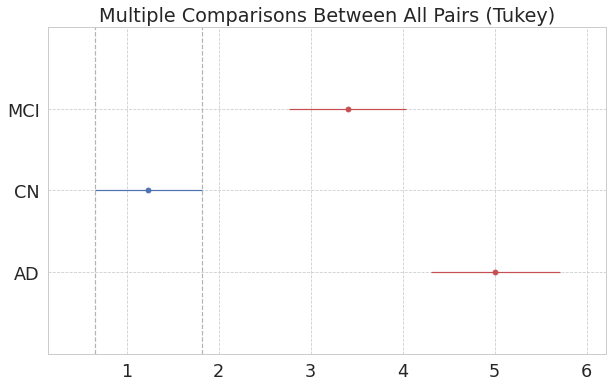

In [45]:
# Tukey’s HSD Post-hoc comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(data['Delta'], data['group'])
mc_results = mc.tukeyhsd(alpha=0.01)
print(mc_results.summary())
mc_results.plot_simultaneous(comparison_name="CN")

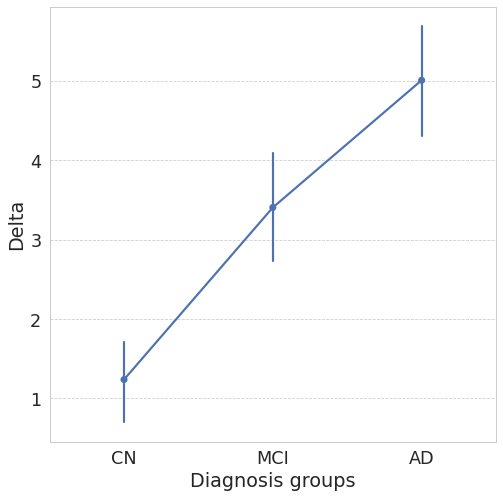

In [48]:
# ax = sns.pointplot(x="group", y="Delta", data=data, order=['CN', 'MCI', 'AD'])
fig= plt.figure(figsize=(8,8))
sns.set(context='paper', 
#         palette='muted', 
        font='sans-serif',
       font_scale=2.0, color_codes=True)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

dt = data[['Delta', 'group']]
dt.columns = ['Delta', 'Diagnosis groups']
sns.pointplot(x="Diagnosis groups", y="Delta", order=['CN', 'MCI', 'AD'],
            showmeans=True, 
            saturation=1.5,
            meanprops={"marker":"o",
                       "markersize":3,
                       "markerfacecolor":"k",
                       "markeredgecolor":"k"
                      },  
                       data=dt, width=0.3)
plt.savefig("anova_pointplot.pdf", bbox_inches='tight')


# Preciso transformar

In [62]:
from sklearn.preprocessing import PowerTransformer
dt = data.Delta + 1 - data.Delta.min()
pt = PowerTransformer(method='box-cox', standardize=True)
pt.fit(dt[:,np.newaxis])
dt3 = pt.transform(dt[:,np.newaxis])
data['Delta2'] = dt3
slr_results = ols('Delta2 ~ C(group)', data=data).fit()
# Shapiro: h0:  normal distribution.
alpha = 0.01
_, p_value = stats.shapiro(slr_results.resid)
print(p_value, "Normal" if p_value>alpha else "Not normal")
# Equal variance
homs = pg.homoscedasticity(data, dv='Delta2', group='group', method="levene", alpha=alpha)
print(homs.pval[0], "Equal var" if homs.equal_var[0] else "Not equal var")

0.03229089826345444 Normal
0.0005780912664072709 Not equal var
ipykernel_launcher:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
ipykernel_launcher:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [63]:
dt = data.Delta
pt = PowerTransformer(method='yeo-johnson', standardize=True)
pt.fit(dt[:,np.newaxis])
dt3 = pt.transform(dt[:,np.newaxis])
data['Delta2'] = dt3
slr_results = ols('Delta2 ~ C(group)', data=data).fit()
# Shapiro: h0:  normal distribution.
alpha = 0.01
_, p_value = stats.shapiro(slr_results.resid)
print(p_value, "Normal" if p_value>alpha else "Not normal")
# Equal variance
homs = pg.homoscedasticity(data, dv='Delta2', group='group', method="levene", alpha=alpha)
print(homs.pval[0], "Equal var" if homs.equal_var[0] else "Not equal var")

0.031380586326122284 Normal
0.0004670223170838248 Not equal var
ipykernel_launcher:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
ipykernel_launcher:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [64]:
dt = data.Delta + 1 - data.Delta.min()
data['Delta2'] = np.log(dt)
slr_results = ols('Delta2 ~ C(group)', data=data).fit()
# Shapiro: h0:  normal distribution.
alpha = 0.01
_, p_value = stats.shapiro(slr_results.resid)
print(p_value, "Normal" if p_value>alpha else "Not normal")
# Equal variance
homs = pg.homoscedasticity(data, dv='Delta2', group='group', method="levene", alpha=alpha)
print(homs.pval[0], "Equal var" if homs.equal_var[0] > alpha else "Not equal var")

3.314370439434623e-17 Not normal
0.0328955058800998 Equal var


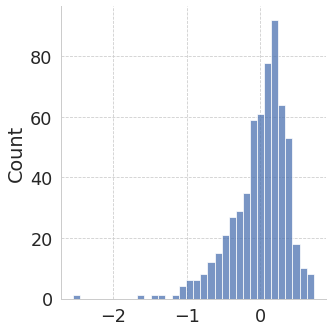

In [26]:
slr_results = ols('Delta2 ~ C(group)', data=data).fit()
sns.displot(slr_results.resid)

In [27]:
rp.summary_cont(data.groupby(['group']))['Delta2']

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
AD,209,2.8060,0.3216,0.0222,2.7622,2.8499
CN,151,2.5481,0.3828,0.0312,2.4865,2.6096
MCI,251,2.6863,0.4128,0.0261,2.6349,2.7376


In [68]:
# data

<AxesSubplot:xlabel='Class', ylabel='Delta'>

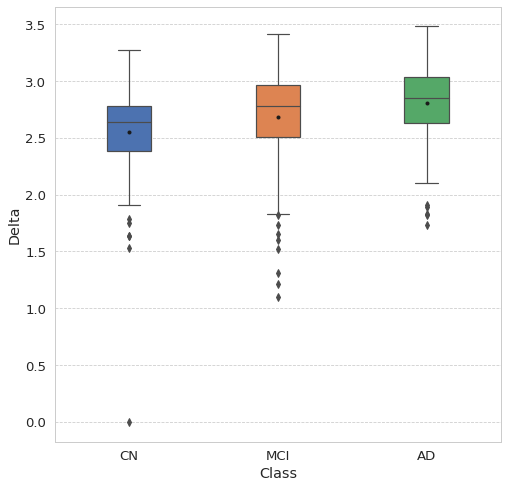

In [28]:
fig= plt.figure(figsize=(8,8))
sns.set(context='paper', 
#         palette='muted', 
        font='sans-serif',
       font_scale=1.5, color_codes=True)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

dt = data[['Delta2', 'group']]
dt.columns = ['Delta', 'Class']
sns.boxplot(x="Class", y="Delta", order=['CN', 'MCI', 'AD'],
            showmeans=True, 
            saturation=1.5,
            meanprops={"marker":"o",
                       "markersize":3,
                       "markerfacecolor":"k",
                       "markeredgecolor":"k"
                      },  
                       data=dt, width=0.3)
# plt.savefig("groups_boxplot_skewness.pdf", bbox_inches='tight')

# plt.legend(loc='upper right', fontsize='small')

In [29]:
slr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Delta2   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     20.67
Date:                Thu, 17 Jun 2021   Prob (F-statistic):           2.07e-09
Time:                        14:13:17   Log-Likelihood:                -268.30
No. Observations:                 611   AIC:                             542.6
Df Residuals:                     608   BIC:                             555.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8060      0.026    107.802      0.000       2.755       2.857
C(group)[T.CN]     -0.2580      0.040     -6.418      0.000      -0.337      -0.179
C(group)[T.MCI]    -0.1198      0.035     -3.399      0.001      -0.189      -0.051
==============================================================================
Omnibus:                      180.294   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.971
Skew:                          -1.364   Prob(JB):                    2.37e-135
Kurtosis:                       7.112   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# Check if tukey's
_, p_value = stats.levene(data['Delta2'][data['group']=='AD'],
                          data['Delta2'][data['group']=='CN'],
                          data['Delta2'][data['group']=='MCI'])

print(p_value, "Equal Var" if p_value>alpha else "Not equal")

0.0328955058800998 Equal Var


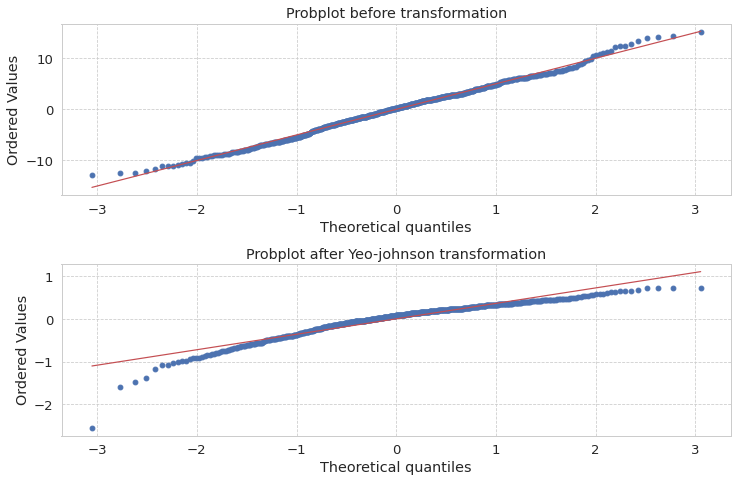

In [31]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1 = fig.add_subplot(311)
prob = stats.probplot(slr_results1.resid, dist=stats.norm, plot=ax1)
ax1.set_title('Probplot before transformation')

ax2 = fig.add_subplot(312)
prob = stats.probplot(slr_results.resid, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Yeo-johnson transformation')
# plt.savefig("probplot_skewnwss.pdf", bbox_inches='tight')
plt.show()

In [32]:
v = rp.summary_cont(data.groupby(['group']))['Delta2']
v

,N,Mean,SD,SE,95% Conf.,Interval
group,,,,,,
AD,209,2.8060,0.3216,0.0222,2.7622,2.8499
CN,151,2.5481,0.3828,0.0312,2.4865,2.6096
MCI,251,2.6863,0.4128,0.0261,2.6349,2.7376


# Todos requisitos atendidos

In [33]:
slr_results = ols('Delta2 ~ group', data=data).fit()
slr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Delta2   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     20.67
Date:                Thu, 17 Jun 2021   Prob (F-statistic):           2.07e-09
Time:                        14:14:39   Log-Likelihood:                -268.30
No. Observations:                 611   AIC:                             542.6
Df Residuals:                     608   BIC:                             555.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8060      0.026    107.802      0.000       2.755       2.857
group[T.CN]     -0.2580      0.040     -6.418      0.000      -0.337      -0.179
group[T.MCI]    -0.1198      0.035     -3.399      0.001      -0.189      -0.051
==============================================================================
Omnibus:                      180.294   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.971
Skew:                          -1.364   Prob(JB):                    2.37e-135
Kurtosis:                       7.112   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
aov_table = sms.anova_lm(slr_results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,5.853284,2.0,20.66792,2.070133e-09
Residual,86.094696,608.0,NaN,NaN


In [35]:
# aov = pg.mixed_anova(dv='AI2', within='gender', between='group', subject='subject', data=data)
# aov
pg.anova(data=data, dv='Delta2', between='group', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,group,5.853284,2,2.926642,20.66792,2.070133e-09,0.063659
1,Within,86.094696,608,0.141603,NaN,NaN,NaN


In [36]:
tt = pg.pairwise_ttests(dv='Delta2', between='group', data=data, alpha=0.01, effsize='hedges', padjust='bonferroni')
# pg.print_table(tt, floatfmt='.3f')
tt

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,group,AD,CN,False,True,6.738393,288.002763,two-sided,8.711983e-11,2.613595e-10,bonferroni,1.219e+08,0.738470
1,group,AD,MCI,False,True,3.495759,456.065059,two-sided,5.189547e-04,1.556864e-03,bonferroni,36.482,0.319585
2,group,CN,MCI,False,True,-3.402829,334.900112,two-sided,7.477537e-04,2.243261e-03,bonferroni,28.369,-0.343297


In [37]:
tk = pairwise_tukey(data=data, dv='Delta2', between='group')
tk

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,AD,CN,2.806024,2.548063,0.257961,0.040191,6.418421,0.001000,0.684079
1,AD,MCI,2.806024,2.686257,0.119767,0.035238,3.398837,0.002082,0.317751
2,CN,MCI,2.548063,2.686257,-0.138195,0.038755,-3.565880,0.001138,-0.366555


## Conclusao:<br>
- p-value: 8.25e-09<br>
- F-stats: 19.08<br>
Portanto, pelo menos uma das médias difere

# Tukey-Kramer test

Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AD     CN   -0.258  0.001 -0.3755 -0.1404   True
    AD    MCI  -0.1198 0.0021 -0.2228 -0.0167   True
    CN    MCI   0.1382 0.0011  0.0249  0.2515   True
----------------------------------------------------
/home/kpoloni/.local/lib/python3.6/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


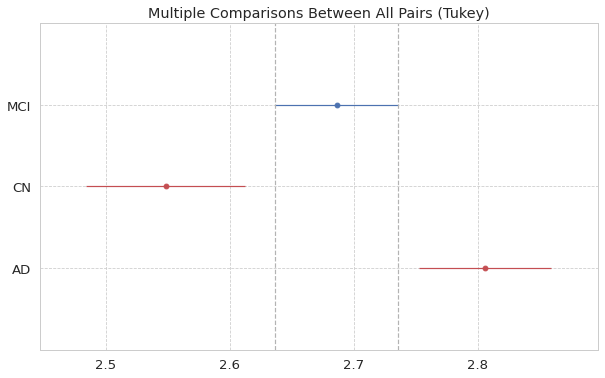

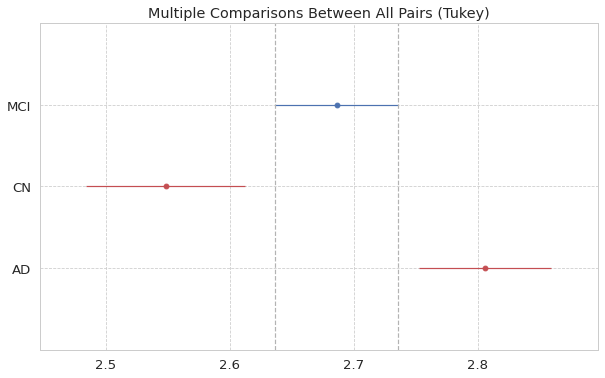

In [38]:
# Tukey’s HSD Post-hoc comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(data['Delta2'], data['group'])
mc_results = mc.tukeyhsd(alpha=0.01)
print(mc_results.summary())
mc_results.plot_simultaneous(comparison_name="MCI")
# mc_results.halfwidths

In [39]:
def anova_table2(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [40]:
def anova_table(aov):
    SSb, SSw = aov[:-1]['sum_sq'], aov['sum_sq'][-1]
    DFb, DFw = aov[:-1]['df'], aov['df'][-1]
    MSb, MSw = SSb/DFb, SSw/DFw
#     aov['mean_sq'] = MSb, MSw
    aov['eta_sq'] = SSb/(SSb+SSw)
    aov['omega_sq'] = (SSb-(DFb*MSw))/(SSb+SSw+MSw)
    cols = ['sum_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

In [41]:
aov_table = sms.anova_lm(slr_results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,5.853284,2.0,20.66792,2.070133e-09
Residual,86.094696,608.0,NaN,NaN


In [42]:
anova_table2(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
group,5.853284,2.0,2.926642,20.66792,2.070133e-09,0.063659,0.060485
Residual,86.094696,608.0,0.141603,NaN,NaN,NaN,NaN
